# Sea ice classification: Histograms
The image histogram provides information we can use to identify which k-means clusters can be labeled as sea ice floes. We use the data loader to access images from the Ice Floe Validation Dataset on Github. The file `data/validation_dataset_testtrain_split.csv` is created in the cloudmask calibration stage and divides cases into testing and training datasets.

In [15]:
using Pkg
Pkg.activate("../scripts/cal-val/")
using Images
using IceFloeTracker

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val`


In [9]:
# This file is in the development version of IFT.jl
# It contains some very nice tools for accessing the validation and calibration dataset
include("/Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/src/validation_data.jl")

[ Info: Precompiling CSVFiles [5d742f6a-9f54-50ce-8119-2520741973ca] (cache misses: wrong dep version loaded (2), incompatible header (4))
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b] (cache misses: wrong dep version loaded (4), incompatible header (6))
[ Info: Precompiling SpecialFunctionsExt [499d2952-c3ce-5339-96ee-b197ee6daaa6] (cache misses: wrong dep version loaded (6), incompatible header (12))
[ Info: Precompiling SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188] (cache misses: wrong dep version loaded (6), incompatible header (12))


_get_file (generic function with 1 method)

In [ ]:
#tbd: load list of training cases here

In [10]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(;case_filter=c -> (
                            c.visible_floes == "yes" &&
                            c.cloud_category_manual == "none" &&
                            c.artifacts == "no"
                        ));

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [20]:
data_loader(;case_filter=c -> (c.visible_sea_ice == "yes" && c.visible_floes == "no"))

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


ValidationDataSet(Base.Generator{DataFrames.DataFrameRows{DataFrame}, var"#5#8"{Watkins2025GitHub}}(var"#5#8"{Watkins2025GitHub}(Watkins2025GitHub("a451cd5e62a10309a9640fbbe6b32a236fcebc70", "https://github.com/danielmwatkins/ice_floe_validation_dataset/", "data/validation_dataset/validation_dataset.csv", "/tmp/Watkins2025")), 84×28 DataFrameRows
 Row │ case_number  region             start_date  center_lon  center_lat  cen ⋯
     │ Int64        String             Date        Float64     Float64     Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           2  baffin_bay         2015-03-12    -81.9643     76.0579   -9 ⋯
   2 │           2  baffin_bay         2015-03-12    -81.9643     76.0579   -9
   3 │           3  baffin_bay         2012-04-19    -79.5793     75.6372   -8
   4 │           3  baffin_bay         2012-04-19    -79.5793     75.6372   -8
   5 │          20  baffin_bay         2007-06-03    -57.4881     72.5214   -4 ⋯
   6 │   

In [ ]:
case = first(data_loader(c -> (c.case_number == 6 && c.satellite == "terra")))

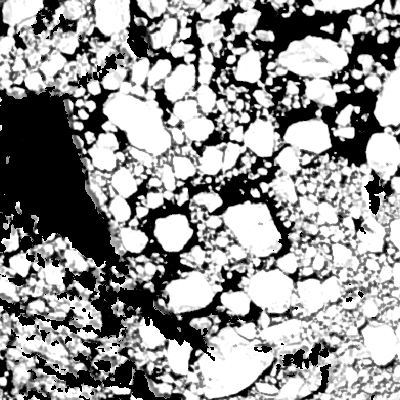

In [86]:
falsecolor = RGB.(case.modis_falsecolor)
truecolor = RGB.(case.modis_truecolor)
landmask = RGB.(case.modis_landmask)
landmask_binary = Gray.(landmask) .> 0
labeled = case.validated_binary_floes
labeled_binary = Gray.(labeled) .> 0
# load morphological residue
mr_dataloc = "../data/validation_dataset/morphological_residue/"
prefix = occursin("terra", case.name) ? replace(case.name, "-terra-250m" => ".terra") : replace(case.name, "-aqua-250m" => ".aqua") 
mr_file = prefix * ".morphed_residue.250m.tiff"
morphed = Gray.(load(joinpath(mr_dataloc, mr_file)))

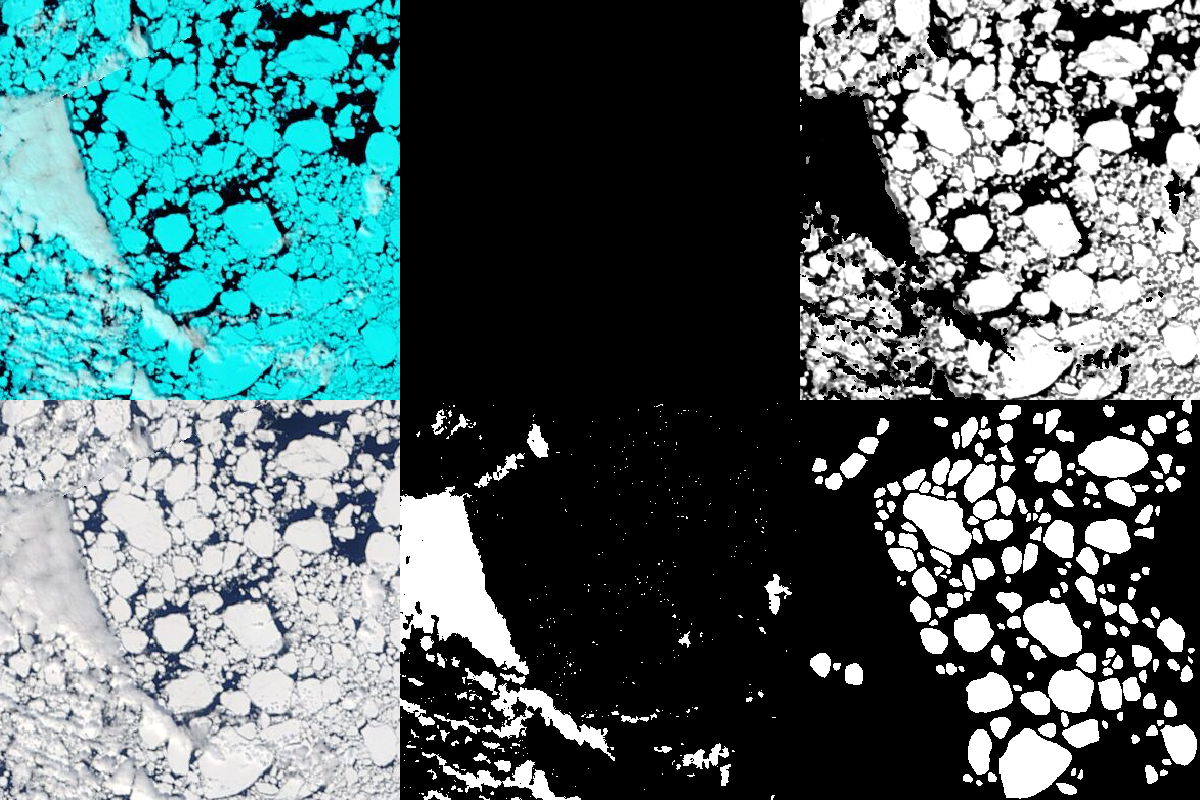

In [71]:
# load cloudmask
cm_dataloc = "../data/validation_dataset/cloudmask/"
prefix = occursin("terra", case.name) ? replace(case.name, "-terra-250m" => ".terra") : replace(case.name, "-aqua-250m" => ".aqua") 
cm_file = prefix * ".cloudmask.250m.tiff"
cloudmask = Gray.(load(joinpath(cm_dataloc, cm_file)) .* 255)
Images.mosaicview(falsecolor, truecolor, landmask, cloudmask, morphed, labeled, nrow=2)

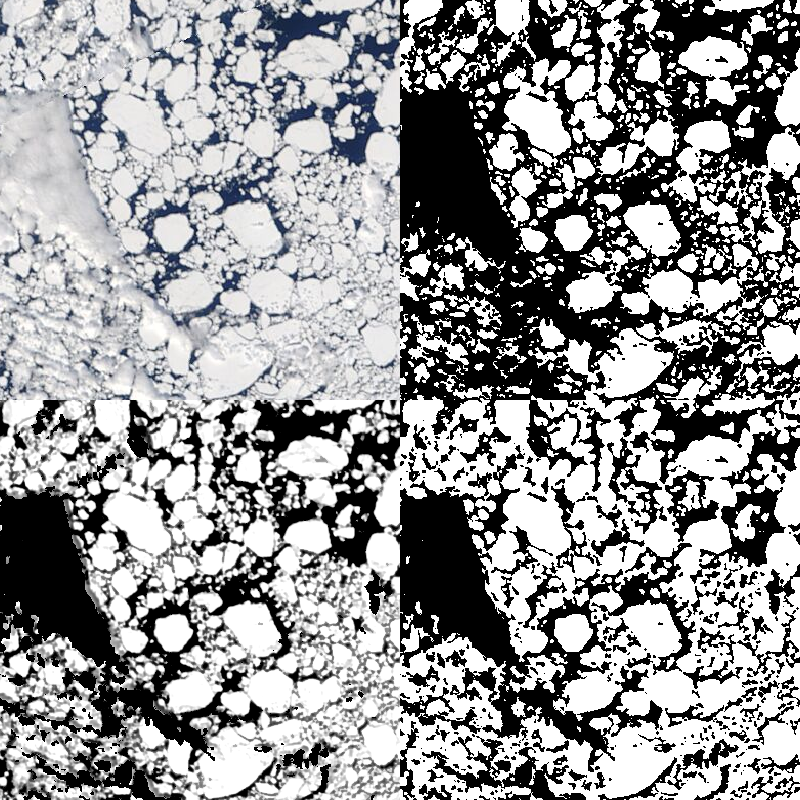

In [52]:
ice_masks_params = (
    band_7_threshold=5,
    band_2_threshold=230,
    band_1_threshold=240,
    band_7_threshold_relaxed=10,
    band_1_threshold_relaxed=190,
    possible_ice_threshold=75,
    k=4, # number of clusters for kmeans segmentation
    factor=255, # normalization factor to convert images to uint8
)
morphed_image_int = Array(Int64.(floor.(Gray.(morphed) .* 255)))
prelim_sizes = size(truecolor) .÷ 2
tiles = IceFloeTracker.get_tiles(truecolor, prelim_sizes[1] + 1)
prelim_icemask, binarized_tiling = IceFloeTracker.get_ice_masks(
        n0f8.(falsecolor), morphed_image_int, landmask_binary, tiles, true; ice_masks_params...
    )
Images.mosaicview([truecolor, morphed, Gray.(prelim_icemask),  Gray.(binarized_tiling)], nrow=2)

Overlay: agreement is white, disagreement is gray

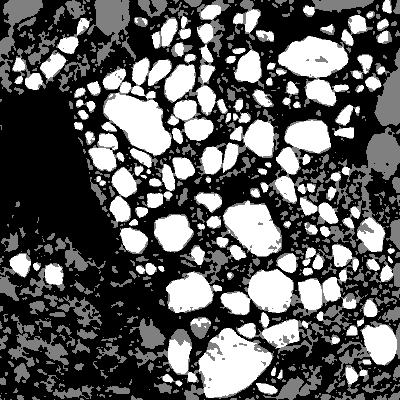

In [57]:
print("Overlay: agreement is white, disagreement is gray")
Images.mosaicview(0.5 .* labeled .+ 0.5 .* prelim_icemask)

In [90]:
function compute_metrics(binary_segmented, binary_labeled, land_mask, cloud_mask)
    valid_idx = (land_mask .== 0) .&& (cloud_mask .== 0)
    agreement = sum(binary_segmented[valid_idx] .&& binary_labeled[valid_idx])
    return (precision=round(agreement/sum(binary_segmented), digits=2),
            recall=round(agreement/sum(binary_labeled), digits=2))
end
compute_metrics(prelim_icemask, labeled_binary, landmask_binary, cloudmask)

(precision = 0.59, recall = 0.87)

In [91]:
compute_metrics(binarized_tiling, labeled_binary, landmask_binary, cloudmask)

(precision = 0.46, recall = 0.95)